In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

plt.style.use("seaborn-v0_8")


In [6]:
data_path = "../data/brent_oil_prices_daily.csv"

df = pd.read_csv(data_path)
df.head()


,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


In [7]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date').reset_index(drop=True)

price_col = 'Price'  # change if your column name is different

df[['Date', price_col]].head()


C:\Users\Robel\AppData\Local\Temp\ipykernel_15736\4008866399.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [8]:
df['log_price'] = np.log(df[price_col])
df['log_return'] = df['log_price'].diff()
df = df.dropna(subset=['log_return']).reset_index(drop=True)

time_idx = np.arange(len(df))
returns = df['log_return'].values

len(time_idx), len(returns)


(9010, 9010)

In [9]:
import pymc as pm
import arviz as az


In [10]:
with pm.Model() as cp_model:
    # Number of observations
    n = len(returns)

    # Prior for change point (tau): discrete uniform over all time indices
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    # Priors for means before and after the change point
    mu_before = pm.Normal("mu_before", mu=0.0, sigma=0.01)
    mu_after = pm.Normal("mu_after", mu=0.0, sigma=0.01)

    # Common standard deviation for returns
    sigma = pm.HalfNormal("sigma", sigma=0.02)

    # Construct the mean for each time index based on tau
    idx = np.arange(n)
    mu_t = pm.math.switch(idx <= tau, mu_before, mu_after)

    # Likelihood: log returns are Normal around mu_t
    y = pm.Normal("y", mu=mu_t, sigma=sigma, observed=returns)


In [12]:
with cp_model:
    trace = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_before, mu_after, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 70 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
az.summary(trace, var_names=["tau", "mu_before", "mu_after", "sigma"])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5865.983,2858.546,358.000,9009.000,322.294,233.648,108.0,346.0,1.10
mu_before,0.000,0.001,-0.001,0.001,0.000,0.000,955.0,324.0,1.01
mu_after,0.001,0.002,-0.001,0.004,0.000,0.000,107.0,210.0,1.03
sigma,0.026,0.000,0.025,0.026,0.000,0.000,4296.0,4455.0,1.00


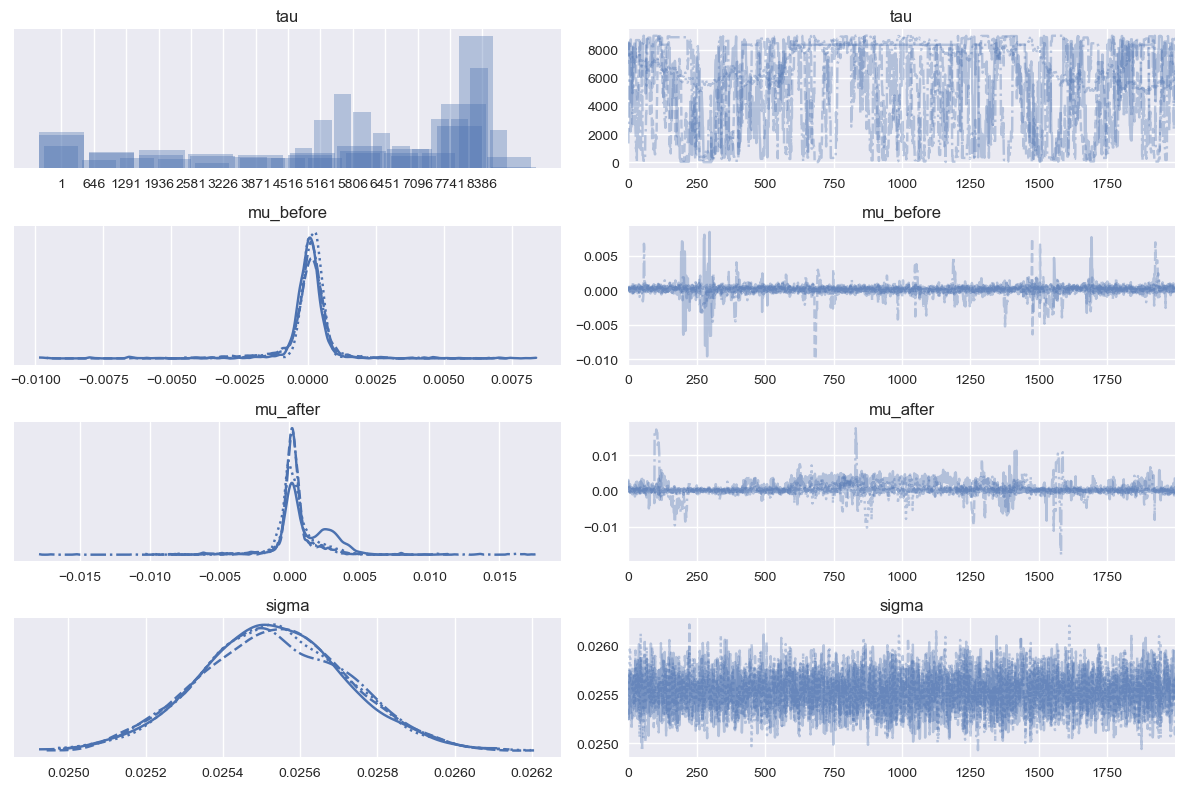

In [14]:
az.plot_trace(trace, var_names=["tau", "mu_before", "mu_after", "sigma"])
plt.tight_layout()
plt.show()


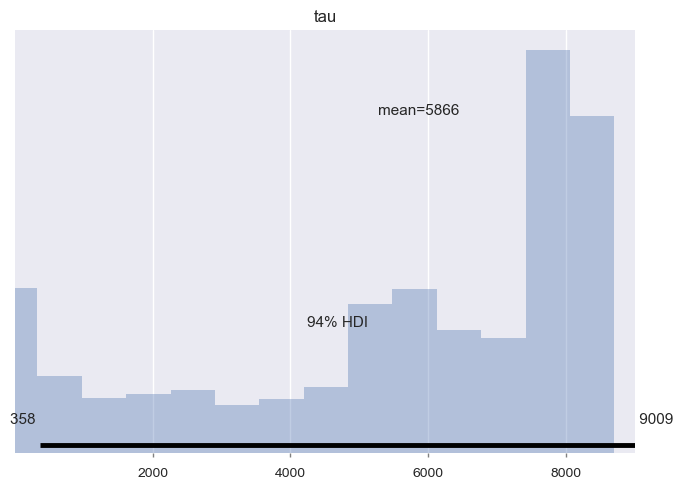

In [15]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()


In [16]:
tau_samples = trace.posterior["tau"].values  # shape: (chains, draws)
tau_mean_idx = int(tau_samples.mean())
tau_median_idx = int(np.median(tau_samples))

change_date_mean = df.loc[tau_mean_idx, "Date"]
change_date_median = df.loc[tau_median_idx, "Date"]

change_date_mean, change_date_median


(Timestamp('2010-06-18 00:00:00'), Timestamp('2013-06-19 00:00:00'))

In [17]:
mu_before_samples = trace.posterior["mu_before"].values.flatten()
mu_after_samples = trace.posterior["mu_after"].values.flatten()

mu_before_mean = mu_before_samples.mean()
mu_after_mean = mu_after_samples.mean()

mu_before_ci = np.percentile(mu_before_samples, [2.5, 97.5])
mu_after_ci = np.percentile(mu_after_samples, [2.5, 97.5])

mu_before_mean, mu_before_ci, mu_after_mean, mu_after_ci


(np.float64(8.274871882507795e-05),
 array([-0.00164991,  0.00118123]),
 np.float64(0.0005790536798247144),
 array([-0.00258304,  0.00407779]))

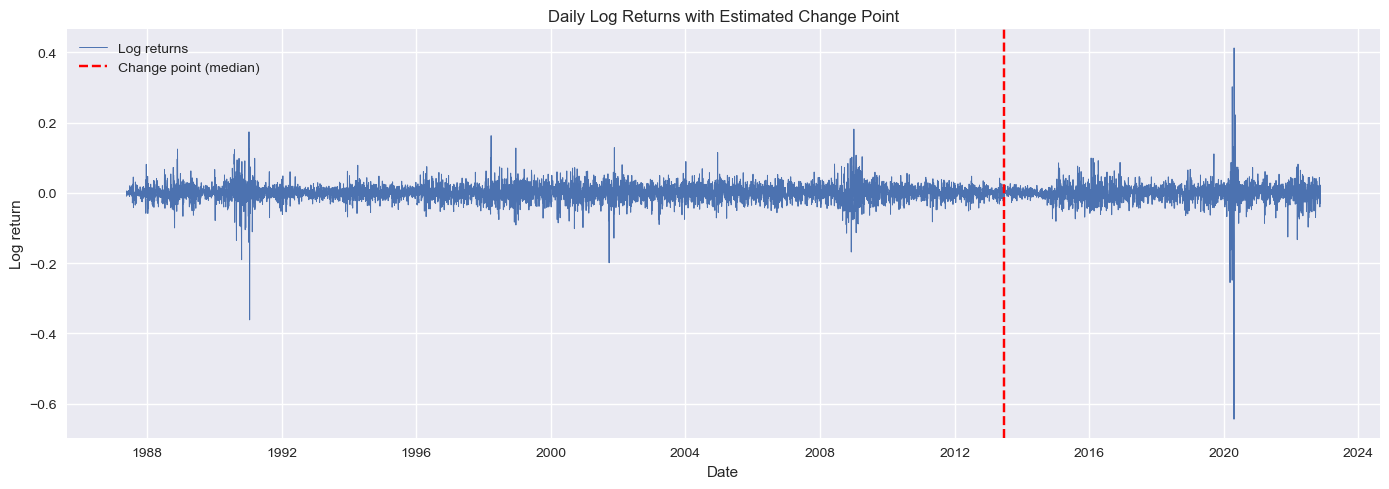

In [18]:
plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["log_return"], linewidth=0.7, label="Log returns")

plt.axvline(change_date_median, color="red", linestyle="--", label="Change point (median)")

plt.title("Daily Log Returns with Estimated Change Point")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
events = pd.read_csv("../data/events_brent_oil.csv", parse_dates=["date"])
events.sort_values("date", inplace=True)
events


,event_id,date,event_name,event_type,description
13,14,2008-07-03,Pre-global financial crisis oil peak,economic,Brent crude reaches record highs before the gl...
14,15,2008-09-15,Lehman Brothers collapse,financial,"Global financial crisis intensifies, triggerin..."
10,11,2011-02-01,Arab Spring unrest,geopolitical,Political unrest across the Middle East and No...
11,12,2012-07-01,EU embargo on Iranian oil,sanctions,European Union implements oil embargo against ...
0,1,2014-06-01,Oil price collapse 2014,economic,Global oil glut and OPEC decision not to cut o...
12,13,2016-01-16,Lifting of some Iran sanctions,sanctions,Implementation of JCPOA eases sanctions on Ira...
1,2,2016-11-30,OPEC production cut 2016,OPEC,OPEC agrees to first production cut since 2008...
2,3,2018-05-08,US withdraws from Iran nuclear deal,geopolitical,United States announces withdrawal from JCPOA ...
3,4,2019-09-14,Saudi Aramco Abqaiq attack,geopolitical,Drone and missile attacks on Saudi oil facilit...
4,5,2020-03-09,COVID-19 demand shock and price war,pandemic,Global demand collapse from COVID-19 and Saudi...


In [20]:
change_date = change_date_median  # from previous cell

# Define a window around the change date, e.g. ±60 days
window = 60

near_events = events[
    (events["date"] >= change_date - pd.Timedelta(days=window)) &
    (events["date"] <= change_date + pd.Timedelta(days=window))
].copy()

near_events


,event_id,date,event_name,event_type,description


In [21]:
before_pct = (np.exp(mu_before_mean) - 1) * 100
after_pct = (np.exp(mu_after_mean) - 1) * 100

before_pct, after_pct


(np.float64(0.008275214259478858), np.float64(0.05792213637711985))

In [22]:
impact_summary = {
    "change_date_median": change_date_median,
    "mu_before_mean": float(mu_before_mean),
    "mu_after_mean": float(mu_after_mean),
    "before_daily_pct": float(before_pct),
    "after_daily_pct": float(after_pct),
}

impact_summary


{'change_date_median': Timestamp('2013-06-19 00:00:00'),
 'mu_before_mean': 8.274871882507795e-05,
 'mu_after_mean': 0.0005790536798247144,
 'before_daily_pct': 0.008275214259478858,
 'after_daily_pct': 0.05792213637711985}

In [24]:
# 1. Save cleaned data with log returns
df_out = df[["Date", price_col, "log_return"]].copy()
df_out.to_csv("../data/brent_prices_with_returns.csv", index=False)

# 2. Save change point summary (single-row CSV or JSON)
cp_summary = pd.DataFrame([impact_summary])
cp_summary.to_csv("../data/change_point_summary.csv", index=False)

